In [1]:
!pip install torch-summary

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files

In [ ]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"csarpalomino","key":"3002ceaaa5c94bd17413b66dfa8a7cd4"}'}

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets list

ref                                                         title                                           size  lastUpdated          downloadCount  voteCount  usabilityRating  
----------------------------------------------------------  ---------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
sudarshan24byte/online-food-dataset                         Online Food Dataset                              3KB  2024-03-02 18:50:30          23197        462  0.9411765        
sahilnbajaj/loans-data                                      Loans Data                                     213KB  2024-04-07 15:08:37            818         23  1.0              
sahirmaharajj/air-pollution-dataset                         Air Pollution Dataset                          213KB  2024-04-07 13:14:48            887         27  1.0              
sanyamgoyal401/customer-purchases-behaviour-dataset         Customer Purchases Behaviour Dataset         

In [ ]:
! kaggle datasets download -d prasoonkottarathil/gananime-lite

100% 8.73G/8.73G [06:41<00:00, 29.1MB/s]
100% 8.73G/8.73G [06:41<00:00, 23.4MB/s]


In [ ]:
! unzip "gananime-lite.zip"

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: out2/seed28784.png      
  inflating: out2/seed28785.png      
  inflating: out2/seed28786.png      
  inflating: out2/seed28787.png      
  inflating: out2/seed28788.png      
  inflating: out2/seed28789.png      
  inflating: out2/seed2879.png       
  inflating: out2/seed28790.png      
  inflating: out2/seed28791.png      
  inflating: out2/seed28792.png      
  inflating: out2/seed28793.png      
  inflating: out2/seed28794.png      
  inflating: out2/seed28795.png      
  inflating: out2/seed28796.png      
  inflating: out2/seed28797.png      
  inflating: out2/seed28798.png      
  inflating: out2/seed28799.png      
  inflating: out2/seed2880.png       
  inflating: out2/seed28800.png      
  inflating: out2/seed28801.png      
  inflating: out2/seed28802.png      
  inflating: out2/seed28803.png      
  inflating: out2/seed28804.png      
  inflating: out2/seed28805.png      
  inflating: out2/seed28806

In [ ]:
import torch
import os
import cv2
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from torch import nn
from torchsummary import summary
import matplotlib.pyplot as plt
from tqdm.auto import tqdm


In [2]:
X_DIM=124
BATCH_SIZE=64
lr=0.0002
device='cuda' if torch.cuda.is_available() else 'cpu'
EPOCHS=50
Z_DIM=100

beta1=0.5
beta2=0.99

In [ ]:
dir_path = '/content/out2'
image_paths = os.listdir(dir_path)


train_augment = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(X_DIM),
    transforms.ToTensor(),
    transforms.Normalize((0, 0, 0), (1, 1, 1)),
])


class AnimeFaces(Dataset):
    def __init__(self, image_paths, augmentations=None):
        self.image_paths = image_paths
        self.augmentations = augmentations
    def __len__(self):
        return len(self.image_paths)
    def __getitem__(self,idx):
        image_path = image_paths[idx]
        try:
            image = cv2.imread(os.path.join(dir_path,image_path))
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            if self.augmentations!=None:
                image = self.augmentations(image)

            return image
        except:
            return self.__getitem__(idx+1)

dataset = AnimeFaces(image_paths, train_augment)

dataloader = DataLoader(dataset, shuffle=True, batch_size=BATCH_SIZE)

print(f"Number of Images: {len(dataset)}, Number of Batches: {len(dataloader)}")

Number of Images: 25664, Number of Batches: 401


In [ ]:
for batch in dataloader:
    break

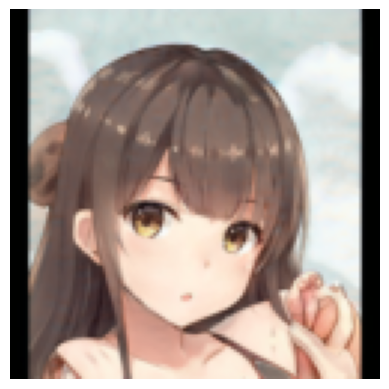

In [ ]:
im = batch[4].permute(1,2,0)
plt.imshow(im)
plt.axis('off')
plt.show()

In [4]:


def disc_block(inc, out, kernel, stride=2):
    return nn.Sequential(
      nn.Conv2d(inc, out, kernel, stride),
      nn.BatchNorm2d(out),
      nn.LeakyReLU(0.2)
      )

class Discriminator(nn.Module):

    def __init__(self):
        super(Discriminator, self).__init__()
        self.b1 = disc_block(3,16,5,2) #124-60
        self.b2 = disc_block(16,32,5,2) #60-28
        self.b3 = disc_block(32,64,5,2) #28-12
        self.b4 = disc_block(64,128,5,2) # 12-4

        self.f = nn.Flatten()
        self.l = nn.Linear(in_features=2048,out_features=1)

    def forward(self, im):
        x1 = self.b1(im)
        x2 = self.b2(x1)
        x3 = self.b3(x2)
        x4 = self.b4(x3)

        x5 = self.f(x4)
        x6 = self.l(x5)
        return x6

disc = Discriminator()
disc.to(device)

if (device == 'cuda'):
    disc = nn.DataParallel(disc)

summary(disc, input_size=(3,124,124))

Layer (type:depth-idx)                   Param #
├─Discriminator: 1-1                     --
|    └─Sequential: 2-1                   --
|    |    └─Conv2d: 3-1                  1,216
|    |    └─BatchNorm2d: 3-2             32
|    |    └─LeakyReLU: 3-3               --
|    └─Sequential: 2-2                   --
|    |    └─Conv2d: 3-4                  12,832
|    |    └─BatchNorm2d: 3-5             64
|    |    └─LeakyReLU: 3-6               --
|    └─Sequential: 2-3                   --
|    |    └─Conv2d: 3-7                  51,264
|    |    └─BatchNorm2d: 3-8             128
|    |    └─LeakyReLU: 3-9               --
|    └─Sequential: 2-4                   --
|    |    └─Conv2d: 3-10                 204,928
|    |    └─BatchNorm2d: 3-11            256
|    |    └─LeakyReLU: 3-12              --
|    └─Flatten: 2-5                      --
|    └─Linear: 2-6                       2,049
Total params: 272,769
Trainable params: 272,769
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Discriminator: 1-1                     --
|    └─Sequential: 2-1                   --
|    |    └─Conv2d: 3-1                  1,216
|    |    └─BatchNorm2d: 3-2             32
|    |    └─LeakyReLU: 3-3               --
|    └─Sequential: 2-2                   --
|    |    └─Conv2d: 3-4                  12,832
|    |    └─BatchNorm2d: 3-5             64
|    |    └─LeakyReLU: 3-6               --
|    └─Sequential: 2-3                   --
|    |    └─Conv2d: 3-7                  51,264
|    |    └─BatchNorm2d: 3-8             128
|    |    └─LeakyReLU: 3-9               --
|    └─Sequential: 2-4                   --
|    |    └─Conv2d: 3-10                 204,928
|    |    └─BatchNorm2d: 3-11            256
|    |    └─LeakyReLU: 3-12              --
|    └─Flatten: 2-5                      --
|    └─Linear: 2-6                       2,049
Total params: 272,769
Trainable params: 272,769
Non-trainable params: 0

In [5]:
def gen_block(inc, out, kernel, stride=2, final_layer=False):
    if final_layer:
        return nn.Sequential(
          nn.ConvTranspose2d(inc, out, kernel, stride),
          nn.Tanh()
            )
    return nn.Sequential(
      nn.ConvTranspose2d(inc, out, kernel, stride),
      nn.BatchNorm2d(out),
      nn.ReLU()
        )

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.g1 = gen_block(Z_DIM,512,5,2) #1-5
        self.g2 = gen_block(512,256,5,2) #5-13
        self.g3 = gen_block(256,128,5,2) #13-29
        self.g4 = gen_block(128,64,5,2) #29-61
        self.g5 = gen_block(64,32,2,2) #61-122
        self.g6 = gen_block(32,3,3,1, final_layer=True) #122-124

    def forward(self, noise):
        inp = noise.view(-1,Z_DIM,1,1)
        x1 = self.g1(inp)
        x2 = self.g2(x1)
        x3 = self.g3(x2)
        x4 = self.g4(x3)
        x5 = self.g5(x4)
        x6 = self.g6(x5)
        return x6

gen = Generator()
gen.to(device)

if (device == 'cuda'):
    gen = nn.DataParallel(gen)

summary(gen, input_size=(64,Z_DIM))

Layer (type:depth-idx)                   Param #
├─Generator: 1-1                         --
|    └─Sequential: 2-1                   --
|    |    └─ConvTranspose2d: 3-1         1,280,512
|    |    └─BatchNorm2d: 3-2             1,024
|    |    └─ReLU: 3-3                    --
|    └─Sequential: 2-2                   --
|    |    └─ConvTranspose2d: 3-4         3,277,056
|    |    └─BatchNorm2d: 3-5             512
|    |    └─ReLU: 3-6                    --
|    └─Sequential: 2-3                   --
|    |    └─ConvTranspose2d: 3-7         819,328
|    |    └─BatchNorm2d: 3-8             256
|    |    └─ReLU: 3-9                    --
|    └─Sequential: 2-4                   --
|    |    └─ConvTranspose2d: 3-10        204,864
|    |    └─BatchNorm2d: 3-11            128
|    |    └─ReLU: 3-12                   --
|    └─Sequential: 2-5                   --
|    |    └─ConvTranspose2d: 3-13        8,224
|    |    └─BatchNorm2d: 3-14            64
|    |    └─ReLU: 3-15                

Layer (type:depth-idx)                   Param #
├─Generator: 1-1                         --
|    └─Sequential: 2-1                   --
|    |    └─ConvTranspose2d: 3-1         1,280,512
|    |    └─BatchNorm2d: 3-2             1,024
|    |    └─ReLU: 3-3                    --
|    └─Sequential: 2-2                   --
|    |    └─ConvTranspose2d: 3-4         3,277,056
|    |    └─BatchNorm2d: 3-5             512
|    |    └─ReLU: 3-6                    --
|    └─Sequential: 2-3                   --
|    |    └─ConvTranspose2d: 3-7         819,328
|    |    └─BatchNorm2d: 3-8             256
|    |    └─ReLU: 3-9                    --
|    └─Sequential: 2-4                   --
|    |    └─ConvTranspose2d: 3-10        204,864
|    |    └─BatchNorm2d: 3-11            128
|    |    └─ReLU: 3-12                   --
|    └─Sequential: 2-5                   --
|    |    └─ConvTranspose2d: 3-13        8,224
|    |    └─BatchNorm2d: 3-14            64
|    |    └─ReLU: 3-15                

In [ ]:
# Test it out
test_vec = torch.rand(1,Z_DIM,1,1,device=device)
test_out = gen(test_vec)
test_pred = disc(test_out)
test_pred.shape

torch.Size([1, 1])

In [ ]:
def weights_init(m):
    if isinstance(m,nn.Conv2d) or isinstance(m,nn.ConvTranspose2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight, 1.0, 0.02)
        nn.init.constant_(m.bias, 0)

gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

In [ ]:
class GANLoss():
    def __init__(self):
        pass
    def real_loss(self,rdp):
        gt = torch.ones_like(rdp)
        rl = nn.BCEWithLogitsLoss()(rdp, gt)
        return rl
    def fake_loss(self,fdp):
        gt = torch.zeros_like(fdp)
        fl = nn.BCEWithLogitsLoss()(fdp, gt)
        return fl

gan_loss = GANLoss()
d_opt = torch.optim.Adam(disc.parameters(),lr=lr,betas=(beta1,beta2))
g_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta1,beta2))

In [ ]:
import numpy as np
bgl, bdl = np.Inf, np.Inf

for i in range(EPOCHS):
    tgl=0.0
    tdl=0.0

    for image in tqdm(dataloader):
        ri = image.to(device)

        d_opt.zero_grad()
        noise = torch.randn(BATCH_SIZE, Z_DIM, device=device)
        fi = gen(noise)
        fdp = disc(fi)
        fl = gan_loss.fake_loss(fdp)

        rdp = disc(ri)
        rl = gan_loss.real_loss(rdp)

        dl = (rl+fl)/2
        tdl += dl
        dl.backward()
        d_opt.step()

        g_opt.zero_grad()
        noise = torch.randn(BATCH_SIZE, Z_DIM, device=device)
        fi = gen(noise)
        fdp = disc(fi)

        gl = gan_loss.real_loss(fdp)
        tgl += gl
        gl.backward()
        g_opt.step()

        gl = tgl/len(dataloader)
        dl = tdl/len(dataloader)


    print(f"G: {gl}, D: {dl}")

    if gl<bgl:
        torch.save(gen.state_dict(),'/content/working/gen.pt')
        print("Gen Updated")
        bgl=gl
    if dl<bdl:
        torch.save(disc.state_dict(),'/content/working/disc.pt')
        print("Disc Updated")
        bdl=dl

print(f"G: {bgl}, D: {bdl}")

  0%|          | 0/401 [00:00<?, ?it/s]

G: 4.121006488800049, D: 0.1504567712545395
Gen Updated
Disc Updated


  0%|          | 0/401 [00:00<?, ?it/s]

G: 4.136144638061523, D: 0.24934370815753937


  0%|          | 0/401 [00:00<?, ?it/s]

G: 1.203172206878662, D: 0.6091687083244324
Gen Updated


  0%|          | 0/401 [00:00<?, ?it/s]

G: 1.0430853366851807, D: 0.6390694379806519
Gen Updated


  0%|          | 0/401 [00:00<?, ?it/s]

G: 0.8645447492599487, D: 0.6777474284172058
Gen Updated


  0%|          | 0/401 [00:00<?, ?it/s]

G: 0.8087344765663147, D: 0.6902391314506531
Gen Updated


  0%|          | 0/401 [00:00<?, ?it/s]

G: 0.9600594639778137, D: 0.6523217558860779


  0%|          | 0/401 [00:00<?, ?it/s]

G: 1.1316816806793213, D: 0.5922837257385254


  0%|          | 0/401 [00:00<?, ?it/s]

G: 0.9861409664154053, D: 0.6379719972610474


  0%|          | 0/401 [00:00<?, ?it/s]

G: 0.8397679328918457, D: 0.6832076907157898


  0%|          | 0/401 [00:00<?, ?it/s]

G: 0.7725296020507812, D: 0.6899186968803406
Gen Updated


  0%|          | 0/401 [00:00<?, ?it/s]

G: 0.7863465547561646, D: 0.6898282766342163


  0%|          | 0/401 [00:00<?, ?it/s]

G: 0.7996711730957031, D: 0.6846495866775513


  0%|          | 0/401 [00:00<?, ?it/s]

G: 0.8440997004508972, D: 0.6779990792274475


  0%|          | 0/401 [00:00<?, ?it/s]

G: 0.8163191676139832, D: 0.6832948327064514


  0%|          | 0/401 [00:00<?, ?it/s]

G: 0.8429418802261353, D: 0.6758310198783875


  0%|          | 0/401 [00:00<?, ?it/s]

G: 0.8173826932907104, D: 0.6777406930923462


  0%|          | 0/401 [00:00<?, ?it/s]

G: 0.8471077084541321, D: 0.6768231987953186


  0%|          | 0/401 [00:00<?, ?it/s]

G: 0.8134365677833557, D: 0.681786060333252


  0%|          | 0/401 [00:00<?, ?it/s]

G: 0.7808801531791687, D: 0.6879618167877197


  0%|          | 0/401 [00:00<?, ?it/s]

G: 0.7856401205062866, D: 0.6891621351242065


  0%|          | 0/401 [00:00<?, ?it/s]

G: 0.7426449656486511, D: 0.694038450717926
Gen Updated


  0%|          | 0/401 [00:00<?, ?it/s]

G: 0.7770717144012451, D: 0.6895402669906616


  0%|          | 0/401 [00:00<?, ?it/s]

(-0.5, 123.5, 123.5, -0.5)

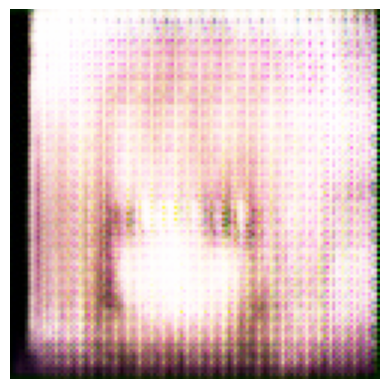

In [6]:
n = torch.randn(1,Z_DIM,1,1, device=device)
gen.load_state_dict(torch.load('/content/working/gen.pt'))

gi = gen(n)

plt.imshow(gi.squeeze(0).permute(1,2,0).detach().cpu().numpy())
plt.axis('off')